# Smooth the Data and Compute Derivatives
The data has a lot of noise in it, which is going to make derivatives particularly problematic

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pandas as pd
import numpy as np

## Load in the Data
We'll use the pickle file saved earlier

In [2]:
raw_data = pd.read_pickle('datasets/initial_data.pkl')
raw_data.head(3)

,void_frac,void_count,radii,radii_average,positions,run_time,created_time,completed_time,mask-path,image-path,...,void_count,radius_total,radius_mean,radius_stddev,surfarea_total,surfarea_mean,surfarea_stddev,volume_total,volume_mean,volume_stddev
319,0.027991,63,"[8.667244841319219, 21.11004122822376, 43.2038...",20.234900,"[[3.76271186440678, 745.3389830508474], [7.582...",0.343604,2023-04-20 09:33:31.827892,2023-04-20 09:46:10.641119,frames/masks/frame-0.tiff,frames/frame-0.tiff,...,73,1435.225919,19.660629,14.367429,543952.0,7451.397260,10352.594839,7.143823e+06,97860.589080,173061.300436
80,0.029204,76,"[21.587164551489145, 42.937755656025104, 9.574...",18.648905,"[[7.816939890710382, 870.9972677595629], [30.9...",0.344804,2023-04-20 09:33:31.827892,2023-04-20 09:44:45.912109,frames/masks/frame-1.tiff,frames/frame-1.tiff,...,96,1692.452142,17.629710,14.395926,624960.0,6510.000000,10677.163981,8.545622e+06,89016.895811,185201.067189
84,0.028668,67,"[20.806283791440396, 43.04141653790755, 11.170...",19.713692,"[[7.279411764705882, 870.9], [30.3725085910652...",0.345819,2023-04-20 09:33:31.835892,2023-04-20 09:44:47.335162,frames/masks/frame-10.tiff,frames/frame-10.tiff,...,96,1701.732359,17.726379,14.368861,628144.0,6543.166667,10688.472138,8.579721e+06,89372.095334,185751.062246


## Determine which data to screen out
There are some initial parts of each measurement series that are reliable. We determined these points by 

In [3]:
cutoff = {
    'void_size_Ni_550C_0.7_to_3dpa_01282022.csv': 1900,
    'void_size_Ni_575C_0.7_to_3dpa_01282022.csv': 100,
    'void_size_Ni_600C_0.7_to_3dpa_01282022.csv': 500
}

Plot the choice

In [4]:
fig, axs = plt.subplots(1, len(set(raw_data.source)), figsize=(6.5, 2.5))

for (gid, group), ax in zip(raw_data.groupby('source'), axs):
    ax.set_title(f'{gid[:16]}...')
    
    ax.plot(group.frame_id, group.radius_mean)
    ax.set_xlabel('Frame')
    
    ax.set_ylim(ax.get_ylim())
    ax.plot([cutoff[gid]]*2, ax.get_ylim(), 'k--')
    
axs[0].set_ylabel('$R_{mean}$ (nm)')
fig.tight_layout()

AttributeError: 'DataFrame' object has no attribute 'source'

Make the change

In [5]:
for source, thr in cutoff.items():
    raw_data.query(f'(source=="{source}" and frame_id >= {thr}) or source != "{source}"', inplace=True)

## Initial Smoothing
Our data has a lot of large jumps, so we'll smooth it out with a median filter first

In [28]:
data = raw_data.copy()  # Make a copy of the raw data first
group = data.drop(columns=['radii', 'positions', 'image-path', 'mask-path', 'frame_id', 'created_time', 'completed_time', 'detect_time', 'filename'])
smoothed_group = group.rolling(65, center=True).median()
data[smoothed_group.columns] = smoothed_group

ValueError: Columns must be same length as key

Now drop off the data near the edges that we could not smooth, which are stored as NaNs

In [7]:
data.dropna(inplace=True)

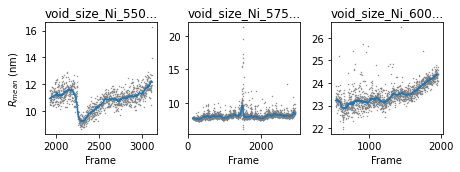

In [8]:
fig, axs = plt.subplots(1, len(set(raw_data.source)), figsize=(6.5, 2.5))

for (gid, group), ax in zip(data.groupby('source'), axs):
    ax.set_title(f'{gid[:16]}...')
    
    ax.plot(group.frame_id, group.radius_mean)
    ax.set_xlabel('Frame')
    
    unsmooth_group = raw_data.loc[group.index]
    ax.scatter(unsmooth_group.frame_id, unsmooth_group.radius_mean, s=0.2, c='gray')

axs[0].set_ylabel('$R_{mean}$ (nm)')
fig.tight_layout()

That reduces the noise significantly, but we should go further to avoid unsmooth derivatives

## Try out smoothing splines
The key way to adjust a spline in scipy's [`UnivariateSpline`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html) is the "smoothing factor," which controls the number of knots on the spline by asserting the error between the spline and the original data stays below a threshold.

We are going to make that threshold equal to 10% of the value fo the data points.

In [9]:
subset = data.query(f'source=="{data.source.iloc[-1]}"')

In [10]:
spline = UnivariateSpline(subset['frame_id'], subset['radius_mean'], k=5, s=(subset['radius_mean'].median() * 0.01) ** 2 * len(data))

Text(0, 0.5, 'Radius (nm)')

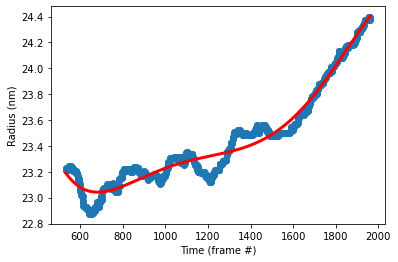

In [11]:
fig, ax = plt.subplots()

x = subset['frame_id']
ax.scatter(subset['frame_id'], subset['radius_mean'])

ax.plot(subset['frame_id'], spline(subset['frame_id']), 'r', lw=3)

ax.set_xlabel('Time (frame #)')
ax.set_ylabel('Radius (nm)')

**TODO**: Probably good enough for the time being, though it seems too smooth. Eventually impose a rule like "select the maximum `s` such that derivatives that there are no outliers above 4 * IQR"

Text(0, 0.5, '$d$Radius/$dt$ (nm/s)')

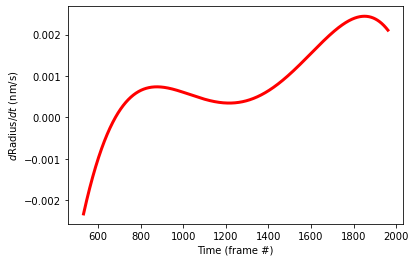

In [12]:
fig, ax = plt.subplots()

ax.plot(x, spline.derivative(1)(x), 'r', lw=3)

ax.set_xlabel('Time (frame #)')
ax.set_ylabel('$d$Radius/$dt$ (nm/s)')

## Run them on all columns
So that we get smooth derivatives for everything

In [13]:
data_cols = data.columns[4:] # Skip frame_id, void_radii, source, temp

In [14]:
smooth_data = data.copy()
for c in tqdm(data_cols):
    dtcol = f'{c}_dt'
    smooth_data[dtcol] = np.nan
    for gid, group in data.groupby('source'):
        # Fit a smoothing spline
        spline = UnivariateSpline(group['frame_id'], group[c], k=5, s=(group[c].median() * 0.01) ** 2 * len(data))

        # Smooth the data
        smooth_data.loc[group.index, c] = spline(group['frame_id'])

        # Compute derivatives of the smoothed data
        smooth_data.loc[group.index, dtcol] = spline.derivative(1)(group['frame_id'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 121.95it/s]


## Save Data
In both CSV and pickle formats

In [15]:
smooth_data.to_csv('datasets/smooth_data.csv', index=False)

In [16]:
smooth_data.to_pickle('datasets/smooth_data.pkl')